In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms

import torchvision
import os
import pickle
import scipy.io
import numpy as np

from torch.autograd import Variable
from torch import optim

import argparse
import os
from torch.backends import cudnn

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset

In [14]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(device)

mps


In [2]:
def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    """Custom deconvolutional layer for simplicity."""
    layers = []
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    """Custom convolutional layer for simplicity."""
    layers = []
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

class G12(nn.Module):
    """Generator for transfering from mnist to svhn"""
    def __init__(self, conv_dim=64):
        super(G12, self).__init__()
        # encoding blocks
        self.conv1 = conv(1, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        
        # residual blocks
        self.conv3 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        self.conv4 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        
        # decoding blocks
        self.deconv1 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 3, 4, bn=False)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)      # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)    # (?, 128, 8, 8)
        
        out = F.leaky_relu(self.conv3(out), 0.05)    # ( " )
        out = F.leaky_relu(self.conv4(out), 0.05)    # ( " )
        
        out = F.leaky_relu(self.deconv1(out), 0.05)  # (?, 64, 16, 16)
        out = F.tanh(self.deconv2(out))              # (?, 3, 32, 32)
        return out

class G21(nn.Module):
    """Generator for transfering from svhn to mnist"""
    def __init__(self, conv_dim=64):
        super(G21, self).__init__()
        # encoding blocks
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        
        # residual blocks
        self.conv3 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        self.conv4 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        
        # decoding blocks
        self.deconv1 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 1, 4, bn=False)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)      # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)    # (?, 128, 8, 8)
        
        out = F.leaky_relu(self.conv3(out), 0.05)    # ( " )
        out = F.leaky_relu(self.conv4(out), 0.05)    # ( " )
        
        out = F.leaky_relu(self.deconv1(out), 0.05)  # (?, 64, 16, 16)
        out = F.tanh(self.deconv2(out))              # (?, 1, 32, 32)
        return out

class D1(nn.Module):
    """Discriminator for mnist."""
    def __init__(self, conv_dim=64, use_labels=False):
        super(D1, self).__init__()
        self.conv1 = conv(1, conv_dim, 4, bn=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        n_out = 11 if use_labels else 1
        self.fc = conv(conv_dim*4, n_out, 4, 1, 0, False)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)    # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)  # (?, 128, 8, 8)
        out = F.leaky_relu(self.conv3(out), 0.05)  # (?, 256, 4, 4)
        out = self.fc(out).squeeze()
        return out

class D2(nn.Module):
    """Discriminator for svhn."""
    def __init__(self, conv_dim=64, use_labels=False):
        super(D2, self).__init__()
        self.conv1 = conv(3, conv_dim, 4, bn=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        n_out = 11 if use_labels else 1
        self.fc = conv(conv_dim*4, n_out, 4, 1, 0, False)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)    # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)  # (?, 128, 8, 8)
        out = F.leaky_relu(self.conv3(out), 0.05)  # (?, 256, 4, 4)
        out = self.fc(out).squeeze()
        return out

In [12]:
def get_loader():
    """Builds and returns Dataloader for MNIST and SVHN dataset."""
    bs_CNN = 64 # batch size
    transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB by replicating channels
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize each channel (assuming mean 0.5, std 0.5 for simplicity)
    ])
    
    train_dataset_source = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
    test_dataset_source = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=True)

    train_dataset_target = datasets.SVHN(root='./svhn_data/', split='train', transform=transform, download=True) # transform to insure same shape and normalisation
    test_dataset_target = datasets.SVHN(root='./svhn_data/', split='test', transform=transform, download=True)

    
    source_loader_train_CNN = torch.utils.data.DataLoader(dataset=train_dataset_source, batch_size=bs_CNN, shuffle=True, drop_last=True)
    source_loader_test_CNN = torch.utils.data.DataLoader(dataset=test_dataset_source, batch_size=bs_CNN, shuffle=False, drop_last=True)
    target_loader_train_CNN = torch.utils.data.DataLoader(dataset=train_dataset_target, batch_size=bs_CNN, shuffle=True, drop_last=True)
    target_loader_test_CNN = torch.utils.data.DataLoader(dataset=test_dataset_target, batch_size=bs_CNN, shuffle=False, drop_last=True)

    return source_loader_train_CNN, source_loader_test_CNN, target_loader_train_CNN, target_loader_test_CNN

In [23]:
class Solver(object):
    def __init__(self, config, svhn_loader, mnist_loader):
        self.svhn_loader = svhn_loader
        self.mnist_loader = mnist_loader
        self.g12 = None
        self.g21 = None
        self.d1 = None
        self.d2 = None
        self.g_optimizer = None
        self.d_optimizer = None
        self.use_reconst_loss = config.use_reconst_loss
        self.use_labels = config.use_labels
        self.num_classes = config.num_classes
        self.beta1 = config.beta1
        self.beta2 = config.beta2
        self.g_conv_dim = config.g_conv_dim
        self.d_conv_dim = config.d_conv_dim
        self.train_iters = config.train_iters
        self.batch_size = config.batch_size
        self.lr = config.lr
        self.log_step = config.log_step
        self.sample_step = config.sample_step
        self.sample_path = config.sample_path
        self.model_path = config.model_path
        self.build_model()
        
    def build_model(self):
        """Builds a generator and a discriminator."""
        self.g12 = G12(conv_dim=self.g_conv_dim)
        self.g21 = G21(conv_dim=self.g_conv_dim)
        self.d1 = D1(conv_dim=self.d_conv_dim, use_labels=self.use_labels)
        self.d2 = D2(conv_dim=self.d_conv_dim, use_labels=self.use_labels)
        
        g_params = list(self.g12.parameters()) + list(self.g21.parameters())
        d_params = list(self.d1.parameters()) + list(self.d2.parameters())
        
        self.g_optimizer = optim.Adam(g_params, self.lr, [self.beta1, self.beta2])
        self.d_optimizer = optim.Adam(d_params, self.lr, [self.beta1, self.beta2])
        
        if torch.cuda.is_available():
            self.g12.cuda()
            self.g21.cuda()
            self.d1.cuda()
            self.d2.cuda()
    
    def merge_images(self, sources, targets, k=10):
        _, _, h, w = sources.shape
        row = int(np.sqrt(self.batch_size))
        merged = np.zeros([3, row*h, row*w*2])
        for idx, (s, t) in enumerate(zip(sources, targets)):
            i = idx // row
            j = idx % row
            merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
            merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
        return merged.transpose(1, 2, 0)
    
    def to_var(self, x):
        """Converts numpy to variable."""
        if torch.cuda.is_available():
            x = x.cuda()
        return Variable(x)
    
    def to_data(self, x):
        """Converts variable to numpy."""
        if torch.cuda.is_available():
            x = x.cpu()
        return x.data.numpy()
    
    def reset_grad(self):
        """Zeros the gradient buffers."""
        self.g_optimizer.zero_grad()
        self.d_optimizer.zero_grad()

    def train(self):
        svhn_iter = iter(self.svhn_loader)
        mnist_iter = iter(self.mnist_loader)
        iter_per_epoch = min(len(svhn_iter), len(mnist_iter))
        
        # fixed mnist and svhn for sampling
        fixed_svhn = self.to_var(next(svhn_iter)[0])
        fixed_mnist = self.to_var(next(mnist_iter)[0])
        
        # loss if use_labels = True
        criterion = nn.CrossEntropyLoss()
        
        for step in range(self.train_iters+1):
            # reset data_iter for each epoch
            if (step+1) % iter_per_epoch == 0:
                mnist_iter = iter(self.mnist_loader)
                svhn_iter = iter(self.svhn_loader)
            
            # load svhn and mnist dataset
            svhn, s_labels = next(svhn_iter) 
            svhn, s_labels = self.to_var(svhn), self.to_var(s_labels).long().squeeze()
            mnist, m_labels = next(mnist_iter) 
            mnist, m_labels = self.to_var(mnist), self.to_var(m_labels)

            if self.use_labels:
                mnist_fake_labels = self.to_var(
                    torch.Tensor([self.num_classes]*svhn.size(0)).long())
                svhn_fake_labels = self.to_var(
                    torch.Tensor([self.num_classes]*mnist.size(0)).long())
            
            #============ train D ============#
            
            # train with real images
            self.reset_grad()
            out = self.d1(mnist)
            if self.use_labels:
                d1_loss = criterion(out, m_labels)
            else:
                d1_loss = torch.mean((out-1)**2)
            
            out = self.d2(svhn)
            if self.use_labels:
                d2_loss = criterion(out, s_labels)
            else:
                d2_loss = torch.mean((out-1)**2)
            
            d_mnist_loss = d1_loss
            d_svhn_loss = d2_loss
            d_real_loss = d1_loss + d2_loss
            d_real_loss.backward()
            self.d_optimizer.step()
            
            # train with fake images
            self.reset_grad()
            fake_svhn = self.g12(mnist)
            out = self.d2(fake_svhn)
            if self.use_labels:
                d2_loss = criterion(out, svhn_fake_labels)
            else:
                d2_loss = torch.mean(out**2)
            
            fake_mnist = self.g21(svhn)
            out = self.d1(fake_mnist)
            if self.use_labels:
                d1_loss = criterion(out, mnist_fake_labels)
            else:
                d1_loss = torch.mean(out**2)
            
            d_fake_loss = d1_loss + d2_loss
            d_fake_loss.backward()
            self.d_optimizer.step()
            
            #============ train G ============#
            
            # train mnist-svhn-mnist cycle
            self.reset_grad()
            fake_svhn = self.g12(mnist)
            out = self.d2(fake_svhn)
            reconst_mnist = self.g21(fake_svhn)
            if self.use_labels:
                g_loss = criterion(out, m_labels) 
            else:
                g_loss = torch.mean((out-1)**2) 

            if self.use_reconst_loss:
                g_loss += torch.mean((mnist - reconst_mnist)**2)

            g_loss.backward()
            self.g_optimizer.step()

            # train svhn-mnist-svhn cycle
            self.reset_grad()
            fake_mnist = self.g21(svhn)
            out = self.d1(fake_mnist)
            reconst_svhn = self.g12(fake_mnist)
            if self.use_labels:
                g_loss = criterion(out, s_labels) 
            else:
                g_loss = torch.mean((out-1)**2) 

            if self.use_reconst_loss:
                g_loss += torch.mean((svhn - reconst_svhn)**2)

            g_loss.backward()
            self.g_optimizer.step()
            
            # print the log info
            if (step+1) % self.log_step == 0:
                print('Step [%d/%d], d_real_loss: %.4f, d_mnist_loss: %.4f, d_svhn_loss: %.4f, '
                      'd_fake_loss: %.4f, g_loss: %.4f' 
                      %(step+1, self.train_iters, d_real_loss.data[0], d_mnist_loss.data[0], 
                        d_svhn_loss.data[0], d_fake_loss.data[0], g_loss.data[0]))

            # save the sampled images
            if (step+1) % self.sample_step == 0:
                fake_svhn = self.g12(fixed_mnist)
                fake_mnist = self.g21(fixed_svhn)
                
                mnist, fake_mnist = self.to_data(fixed_mnist), self.to_data(fake_mnist)
                svhn , fake_svhn = self.to_data(fixed_svhn), self.to_data(fake_svhn)
                
                merged = self.merge_images(mnist, fake_svhn)
                path = os.path.join(self.sample_path, 'sample-%d-m-s.png' %(step+1))
                scipy.misc.imsave(path, merged)
                print ('saved %s' %path)
                
                merged = self.merge_images(svhn, fake_mnist)
                path = os.path.join(self.sample_path, 'sample-%d-s-m.png' %(step+1))
                scipy.misc.imsave(path, merged)
                print ('saved %s' %path)
            
            if (step+1) % 5000 == 0:
                # save the model parameters for each epoch
                g12_path = os.path.join(self.model_path, 'g12-%d.pkl' %(step+1))
                g21_path = os.path.join(self.model_path, 'g21-%d.pkl' %(step+1))
                d1_path = os.path.join(self.model_path, 'd1-%d.pkl' %(step+1))
                d2_path = os.path.join(self.model_path, 'd2-%d.pkl' %(step+1))
                torch.save(self.g12.state_dict(), g12_path)
                torch.save(self.g21.state_dict(), g21_path)
                torch.save(self.d1.state_dict(), d1_path)
                torch.save(self.d2.state_dict(), d2_path)

In [18]:
config = {      "image_size":           32,
                "g_conv_dim":           64,
                "d_conv_dim":           64,
                "use_reconst_loss":     True,
                "use_labels":           False,
                "num_classes":          10,
                "train_iters":          40000,
                "batch_size":           64,
                "num_workers":          2,
                "lr":                   0.0002,
                "beta1":                0.5,
                "beta2":                0.999,
                "mode":                 "train", 
                "model_path":           "./models",
                "sample_path":          "./samples",
                "mnist_path":           "./mnist",
                "svhn_path":            "./svhn",
                "log_step":             10,
                "sample_step":          500
                                                    }

class DotDict:
    def __init__(self, data):
        self._data = data

    def __getattr__(self, name):
        if name in self._data:
            return self._data[name]
        else:
            raise AttributeError(f"'{type(self).__name__}' object has no attribute '{name}'")

config = DotDict(config)

In [ ]:
# svhn_loader, mnist_loader = get_loader()
source_loader_train_CNN, source_loader_test_CNN, target_loader_train_CNN, target_loader_test_CNN = get_loader()

solver = Solver(config, target_loader_train_CNN, source_loader_train_CNN)
cudnn.benchmark = True 

# create directories if not exist
if not os.path.exists(config.model_path):
    os.makedirs(config.model_path)
if not os.path.exists(config.sample_path):
    os.makedirs(config.sample_path)

if config.mode == 'train':
    solver.train()
elif config.mode == 'sample':
    solver.sample()

In [25]:
from torchvision.datasets import MNIST, SVHN
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
mnist_dataset = MNIST(root='./data', train=True, transform=transform, download=True)

# Load SVHN dataset
svhn_dataset = SVHN(root='./data', split='train', transform=transform, download=True)

# Define data loaders
batch_size = 64
mnist_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)
svhn_loader = DataLoader(svhn_dataset, batch_size=batch_size, shuffle=True)

Using downloaded and verified file: ./data/train_32x32.mat


In [ ]:
for i, (mnist_images, svhn_images) in enumerate(zip(mnist_loader, svhn_loader)):
    print(i)
    print(type(mnist_images))
    print(type(mnist_images[0]))
    print(type(mnist_images[1]))

In [45]:
next(iter((mnist_loader)))[0].shape

torch.Size([64, 1, 28, 28])

In [47]:
model_SVHN2MNIST = torch.load("./saved_models/G_SVHN2MNIST_epoch_20.pth")

# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
mnist_dataset = MNIST(root='./data', train=True, transform=transform, download=True)

# Load SVHN dataset
svhn_dataset = SVHN(root='./data', split='train', transform=transform, download=True)

Using downloaded and verified file: ./data/train_32x32.mat


In [53]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        residual = x
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        x += residual
        return x
        
class Generator(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=1, padding=3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.residual_blocks = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256)
        )
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv4 = nn.Conv2d(64, output_channels, kernel_size=7, stride=1, padding=3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.residual_blocks(x)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.tanh(self.conv4(x))
        return x

Using downloaded and verified file: ./svhn_data/test_32x32.mat


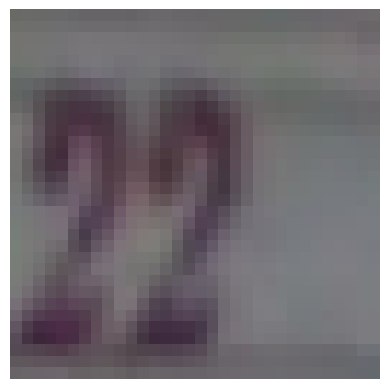

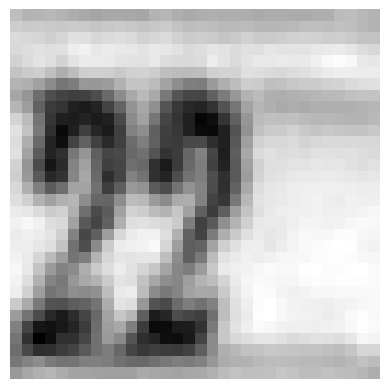

In [116]:
test_dataset_target = datasets.SVHN(root='./svhn_data/', split='test', transform=transform, download=True)

generator = Generator(3, 1)
generator.load_state_dict(model_SVHN2MNIST)
generator.eval()

idx = 2356
svhn_image = test_dataset_target[idx][0]

with torch.no_grad():
    # Pass the preprocessed SVHN image through the generator
    mnist_style_image = generator(svhn_image.unsqueeze(0))

svhn_image = test_dataset_target.data[idx].transpose((1, 2, 0))
plt.imshow(svhn_image)
plt.axis('off')
plt.show()

mnist_style_image_np = mnist_style_image.squeeze().detach().cpu().numpy()

# Plot the image
plt.imshow(mnist_style_image_np, cmap='gray')  # Assuming the image is grayscale
plt.axis('off')
plt.show()

In [79]:
####################################################
# DEFINE A CNN MODEL (WITH SRIVASTAVA ARCHITECTURE)
####################################################

class CNN(nn.Module):
    
    def __init__(self):
        
        super(CNN, self).__init__()
        
        # Convolutional layers with padding
        self.conv1 = nn.Conv2d(3, 96, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(96, 128, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2)
        
        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        
        # Fully connected layers for the main task
        self.fc1_main = nn.Linear(256 * 3 * 3, 2048)  # Adjusted based on feature map size
        self.fc2_main = nn.Linear(2048, 2048)
        self.fc3_main = nn.Linear(2048, 10)

        # Dropout layers
        self.dropout1 = nn.Dropout(p=0.1)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.5)
        self.dropout5 = nn.Dropout(p=0.5)
        self.dropout6 = nn.Dropout(p=0.5)

        # Softmax layer for the main task
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        # Convolutional layers with ReLU activation and max pooling
        class_x = F.relu(self.pool(self.conv1(x)))
        class_x = self.dropout1(class_x)
        class_x = F.relu(self.pool(self.conv2(class_x)))
        class_x = self.dropout2(class_x)
        class_x = F.relu(self.pool(self.conv3(class_x)))
        class_x = self.dropout3(class_x)
        # Flatten the output for the fully connected layers
        extracted_features = class_x.view(-1, 256 * 3 * 3)
                
        # Fully connected layers for the main task
        class_x = F.relu(self.fc1_main(extracted_features))
        class_x = self.dropout4(class_x)
        class_x = F.relu(self.fc2_main(class_x))
        class_x = self.dropout5(class_x)
        class_x = self.fc3_main(class_x)
        # class_X = self.softmax(class_x) # not needed as we will use nn.CrossEntropyLoss (which automatically applies softmax)

        return class_x

In [87]:
########################################################################################
#
# DEFINE THE TRAINING FUNCTION FOR THE MAIN CLASSIFIER
#
# evaluate_CNN(model, data_loader) : function to evaluate the model during training
# train_CNN(model, loader_train, loader_test, epochs=10, lr=0.001) : function to train the model
#
# get_proba_pred(model, data_loader) : function to get the predictions and probabilities
# get_confusion_matrix( y_pred, y_true, title='') : function to get and show confusion matrix
# get_confusion_matrix_from_loader(model, data_loader,title='') : function to get and show confusion matrix
# generate_pseudo_labels(X, y_pred , y_proba, threshold=0.9) : function to generate pseudo labels
# balance_pseudo_labels(pseudo_labels, confident_indices) : function to balance pseudo labels
#
# SVHNWithPseudoLabels(Dataset) : class to create a dataset with pseudo labels
#
########################################################################################

            
def evaluate_CNN(model, data_loader):
    '''evaluation function to be called every 100 batches and after each epoch''' 
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    #print('Accuracy of the model on the test images: %d %%' % (100 * correct / total))
    
    return correct / total         

def apply_max_norm(model, max_val=4):
    for param in model.parameters():
        norm = param.data.norm(2)
        desired = torch.clamp(norm, 0, max_val)
        scale = desired / (norm + 1e-7)
        param.data.mul_(scale)
        
def train_CNN(model, loader_train, loader_test, optimizer , epochs=10, lr=0.001):
    '''A function to train the model (will evaluate on the test set after each epoch)
    note : Adam optimiser is used with learning rate = 0.0001 isntead of SGD with max-norma=4
    in the original paper (Srivastava et al. 2014), quicker convergence and better accuracy are obtained''' 

    # Calculate weights for the loss function
    Y_train = torch.cat([labels for _, labels in loader_train])
    Y_train = Y_train.numpy()
    class_weights = compute_class_weight('balanced', classes = np.unique(Y_train), y = Y_train)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight = class_weights)
    #optimizer = optim.Adam(model.parameters(), lr=lr)
        
    model.train()
        
    for epoch in range(epochs):
        
        model.train()   
        running_loss = 0.0

        running_loss = 0.0
        running_correct = 0
        total_samples = 0
            
        for i, (images, labels) in enumerate(loader_train):
                
            # Send the data to the device
            images, labels = images.to(device), labels.to(device)
                
            # training step for single batch
            optimizer.zero_grad()
            outputs = model(images) # Forward pass
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Apply max-norm constraint
            # apply_max_norm(model, 4)  # slows down considerably the learning (80% ater 15epochs instead of 97% after 2 epochs)

            # Increment statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            running_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            #Print statistics

            if (i+1) % 200 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Batch [{i + 1}/{len(loader_train)}], Loss: {loss.item():.4f}, Running loss: {running_loss/total_samples:.4f}, Running accuracy on train: {round(running_correct / total_samples * 100 , 2):.4f} %')
                #print('Epoch: %d, Batch: %5d, Loss: %.3f' % (epoch + 1, i +1 , loss.item()))
                #print(f'Epoch [{epoch + 1}/{epochs}], Batch [{i + 1}/{len(loader_train)}], Loss: {loss.item():.4f}, Accuracy on train: {evaluate_CNN(model, loader_train[i]):.4f}')        #Evaluation
            
            # reset running statistics
            running_loss = 0.0
            running_correct = 0
            total_samples = 0

        # Evaluate after each epoch
        train_accuracy = evaluate_CNN(model, loader_train)
        test_accuracy = evaluate_CNN(model, loader_test)
        print(f'End of Epoch {epoch + 1}: Train Accuracy: {train_accuracy:.4f}%, Test Accuracy: {test_accuracy:.4f}%')
    
    print('Finished Training')


def get_proba_pred(model, data_loader):
    '''function to get the predictions and probabilities of the model on a dataloader
    '''
    model.eval()
    y_true = []
    y_pred = []
    y_proba = []
    

    # Obtain predicted labels
    with torch.no_grad():
        for images, labels in data_loader:
            pred_batch_logits = model(images.to(device)) # no softmax applied in forward pass (CrossEntropyLoss does it automatically)
            pred_batch_proba = F.softmax(pred_batch_logits, dim=1) # apply softmax to get probabilities
            pred_batch_proba_np = pred_batch_proba.cpu().detach().numpy()       
            _ , pred_batch = torch.max(pred_batch_proba.data, 1)
            pred_batch = pred_batch.cpu().detach().numpy()
            pred_batch_proba = pred_batch_proba.cpu().detach().numpy()
            
            y_true.extend(labels)
            y_pred.extend(pred_batch) 
            y_proba.extend(pred_batch_proba_np)
            
    return y_true, y_pred, y_proba

def get_confusion_matrix( y_pred, y_true, title=''):
    '''a function to get and show confusion matrix from numpy arrays
    '''
    # Create confusion matrix and show it
    cf = confusion_matrix( y_pred, y_true)

    # Print statistics with confusion matrix
    correct_count = np.trace(cf) # sums the diagonal (all true values) 
    accuracy = correct_count / np.sum(cf)

    # Print statistics by class with confusion matrix 
    y_true_count = np.sum(cf,axis=0) # sums the columns (all true values)
    y_pred_count = np.sum(cf,axis=1) # sums the rows (all predicted values)
    y_correct_pred_count = np.diag(cf) # returns the vector of the diagonal (all true values)
    accuracy_by_class = np.round(y_correct_pred_count/y_true_count, 2)
    print('distribution (true label):\n',np.round(y_true_count/len(y_pred)*100,2))
    print('prediction distribution:\n',np.round(y_pred_count/len(y_pred)*100,2))
    print('accuracy by class:\n',np.round(accuracy_by_class*100, 2))

    # Plot the confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cf, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.title(f'Confusion Matrix {title} (accuracy {round(accuracy*100,2)}%)')
    plt.show()
    
    return cf


# function to get and show confusion matrix from dataloader

def get_confusion_matrix_from_loader(model, data_loader,title=''):
    '''a function to get and show confusion matrix from a dataloader
    Returns confusion matrix, true labels, predicted labels and probabilities'''
    y_true, y_pred, y_proba = get_proba_pred(model, data_loader)
    cf = get_confusion_matrix( y_pred, y_true, title)
    return cf, y_true, y_pred, y_proba

# get speudo labels for SVHN for confident data
#----------------------------------------------
# Get confident predictions
# Define confidence threshold

def generate_pseudo_labels(X, y_pred , y_proba, threshold=0.9):
    '''function to generate pseudo labels for confident predictions
    '''    
    # Select highest probability for each sample (among vectore of 10 probabilities)
    max_proba = np.max(y_proba, axis=1)  # shape (n,1) from vector of probabilities of shape (n,10)

    # Get confident indices, confident images and pseudo labels
    confident_indices = np.where(max_proba > threshold)[0]
    confident_indices = np.array(confident_indices)
    np.random.shuffle(confident_indices)
    X_confident = X[confident_indices]
    pseudo_labels = np.array(y_pred)[confident_indices]
    return pseudo_labels, confident_indices # X_confident not returned because of numpy array type

def balance_pseudo_labels(pseudo_labels, confident_indices):
    '''function to balance pseudo labels by hedging classes over 10%
    '''
    # check if pseudo labels and indices have the same length
    print(len(pseudo_labels)==len(confident_indices))

    # Get the count and distribution of pseudo labels
    pseudo_labels_count = np.bincount(pseudo_labels)
    print('pseudo labels count:\n',pseudo_labels_count)
    distribution = np.bincount(pseudo_labels)/ len(confident_indices)
    print('distribution of pseudo labels:\n',np.round(distribution*100,2))

    # Hedge the distribution when > 10%
    max_n_per_class = int(0.05 * np.sum(np.maximum(pseudo_labels_count,0.05*len(pseudo_labels))))  # 10% hedge
    print('max number of samples per class (10%):',max_n_per_class)

    # Select indices of pseudo labels to keep for each class
    indices_to_keep = []
    indices_to_remove = []

    for i in range(10):
        indices_i = confident_indices[pseudo_labels == i]
        
        if pseudo_labels_count[i] <= max_n_per_class : # check if there are indices to remove for class i
            indices_to_keep.extend(indices_i) # add all indices to indices_to_keep
        else:
            indices_to_keep_i = np.random.choice(indices_i, max_n_per_class, replace=False) # select randomly indices to keep
            # get indices to remove
            indices_to_remove_i = np.array([ indice for indice in indices_i if indice not in indices_to_keep_i])
            # add indices to keep and to remove to their respective lists
            indices_to_keep.extend(indices_to_keep_i)
            indices_to_remove.extend(indices_to_remove_i)
    
    # format indices to keep and pseudo labels to keep
    indices_to_keep = np.array(indices_to_keep)
    np.random.shuffle(indices_to_keep)
    indices_to_remove = np.array(indices_to_remove)

    # get pseudo labels to keep
    positions_to_keep = [list(confident_indices).index(indice) for indice in indices_to_keep]
    pseudo_labels_to_keep = pseudo_labels[positions_to_keep]

    # print new distribution, number of indices to keep and remove
    balanced_distribution = np.bincount(pseudo_labels_to_keep)/ len(indices_to_keep)
    print('Distribution of balanced pseudo labels:\n',np.round(balanced_distribution*100,2))
    print('Number of samples to keep:',len(indices_to_keep))
    print('Number of samples to remove:',len(indices_to_remove))

    return pseudo_labels_to_keep, indices_to_keep, indices_to_remove

class SVHNWithPseudoLabels(Dataset):
    def __init__(self, original_dataset, confident_indices, pseudolabels):
        """
        original_dataset: The original SVHN dataset object.
        confident_indices: A list of indices for which you have pseudo labels.
        pseudolabels: A list or array of pseudolabels corresponding to the confident_indices.
        """
        self.original_dataset = original_dataset
        self.confident_indices = confident_indices
        self.pseudolabels = pseudolabels

    def __len__(self):
        return len(self.confident_indices)

    def __getitem__(self, idx):
        # Use the confident index to access the original dataset
        original_idx = self.confident_indices[idx]
        image, _ = self.original_dataset[original_idx]  # Get the image, ignore its original label
        pseudolabel = self.pseudolabels[idx]  # Get the pseudolabel corresponding to the confident index
        return image, pseudolabel
    

In [88]:
model_CNN = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_CNN.parameters(), lr=0.0001)  # !!! DO NOT CHANGE LEARNING RATE IF ADAM OPTIMISER USED !!!
n_epochs = 3

# Train the model
history_CNN = train_CNN(model_CNN, source_loader_train_CNN, source_loader_test_CNN,  optimizer, epochs=n_epochs, lr=0.0001) #!!! KEEP LEARNING RATE = 0.0001 IF ADAM OPTIMISER USED !!!

Epoch [1/3], Batch [200/937], Loss: 0.2341, Running loss: 0.0037, Running accuracy on train: 90.6200 %
Epoch [1/3], Batch [400/937], Loss: 0.1304, Running loss: 0.0020, Running accuracy on train: 96.8800 %
Epoch [1/3], Batch [600/937], Loss: 0.1267, Running loss: 0.0020, Running accuracy on train: 96.8800 %
Epoch [1/3], Batch [800/937], Loss: 0.0207, Running loss: 0.0003, Running accuracy on train: 98.4400 %
End of Epoch 1: Train Accuracy: 0.9841%, Test Accuracy: 0.9873%
Epoch [2/3], Batch [200/937], Loss: 0.0090, Running loss: 0.0001, Running accuracy on train: 100.0000 %
Epoch [2/3], Batch [400/937], Loss: 0.0123, Running loss: 0.0002, Running accuracy on train: 100.0000 %
Epoch [2/3], Batch [600/937], Loss: 0.0656, Running loss: 0.0010, Running accuracy on train: 98.4400 %
Epoch [2/3], Batch [800/937], Loss: 0.0256, Running loss: 0.0004, Running accuracy on train: 98.4400 %
End of Epoch 2: Train Accuracy: 0.9881%, Test Accuracy: 0.9905%
Epoch [3/3], Batch [200/937], Loss: 0.0196, Ru

distribution (true label):
 [ 9.81 11.35 10.32 10.1   9.82  8.91  9.58 10.29  9.75 10.1 ]
prediction distribution:
 [ 9.92 11.43 10.41 10.15  9.85  8.78  9.47 10.2   9.67 10.15]
accuracy by class:
 [100. 100. 100. 100.  99.  99.  99.  98.  99.  99.]


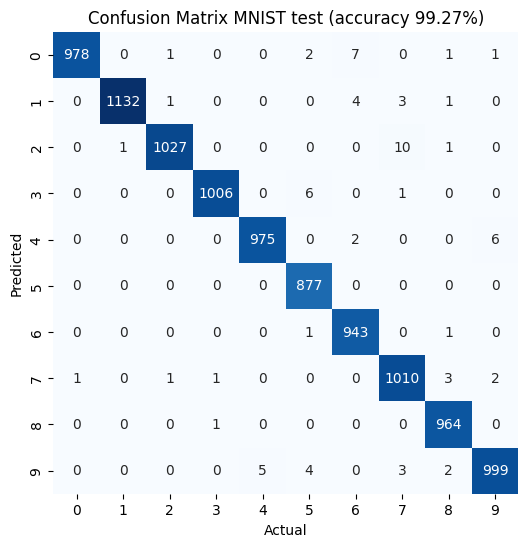

distribution (true label):
 [ 6.7  19.59 15.94 11.07  9.69  9.16  7.58  7.76  6.38  6.13]
prediction distribution:
 [11.31 59.27  5.39  3.23  4.39  3.54  1.88  3.38  5.9   1.7 ]
accuracy by class:
 [30. 92. 24. 19. 17. 24. 14. 21. 21. 13.]


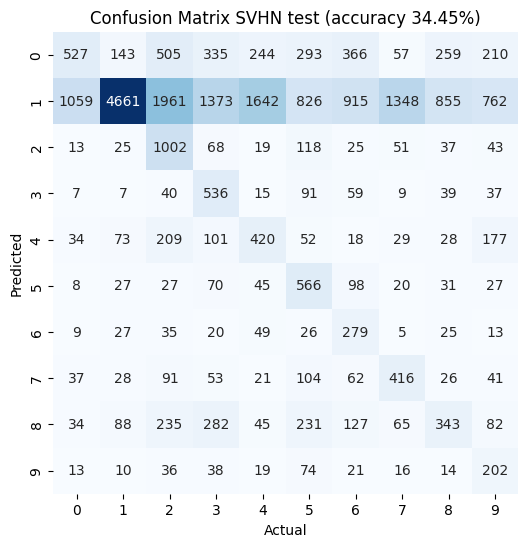

probabilities min/max: 9.419886e-18 1.0
predictions: [0 1 2 3 4 5 6 7 8 9]


In [89]:
CFs_test , Ys_test, Ys_pred_test, Ys_proba_test = get_confusion_matrix_from_loader(model_CNN, source_loader_test_CNN,'MNIST test')
CFt_test, Yt_test, Yt_pred_test, Yt_proba_test = get_confusion_matrix_from_loader(model_CNN, target_loader_test_CNN,'SVHN test')

# check predictions and probabilities outputs
print('probabilities min/max:',np.min(Ys_proba_test),np.max(Ys_proba_test))
print('predictions:', np.unique(Ys_pred_test))

In [95]:
# Create new data
new_data = []
for data, label in test_dataset_target:
    with torch.no_grad():
        # Pass the preprocessed SVHN image through the generator
        mnist_style_image = generator(data.unsqueeze(0))
    new_data.append(mnist_style_image)

In [109]:
new_data[0].shape

torch.Size([1, 1, 32, 32])

In [114]:
new_data[0].shape

torch.Size([1, 1, 32, 32])

In [110]:
test_dataset_target[0][0].shape

torch.Size([3, 32, 32])

In [111]:
train_datatrain_dataset_source = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
train_datatrain_dataset_source[0][0].shape

torch.Size([1, 28, 28])

In [113]:
model_CNN.eval()
resp = model_CNN(train_datatrain_dataset_source[0][0])

RuntimeError: Given groups=1, weight of size [96, 3, 5, 5], expected input[1, 1, 28, 28] to have 3 channels, but got 1 channels instead

In [104]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        return sample, label
custom_dataset = CustomDataset(new_data, test_dataset_target.labels)
new_data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

In [105]:
CFt_test, Yt_test, Yt_pred_test, Yt_proba_test = get_confusion_matrix_from_loader(model_CNN, new_data_loader,'New Data')

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [64, 1, 1, 32, 32]